<a href="https://colab.research.google.com/github/anshupandey/AIOps-EL/blob/main/part3_standard_code_with_mlflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Quality of Service (QoS) Metrics for 5G Network Optimization

In [ ]:
!pip install mlflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.1/575.1 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.6 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import mlflow
import mlflow.sklearn

In [ ]:
!wget -q https://www.dropbox.com/scl/fi/0rncal8biwhhw5opxyxz6/Quality-of-Service-5G.xlsx?rlkey=gdoq5hw1fgc60khl3equbreyn&st=uzqgtrca&dl=0
!mv Quality-of-Service-5G.xlsx?rlkey=gdoq5hw1fgc60khl3equbreyn Quality-of-Service-5G.xlsx

In [ ]:
# Load the dataset
file_path = 'Quality-of-Service-5G.xlsx'
data = pd.read_excel(file_path, sheet_name='in')
data.shape

(400, 8)

In [ ]:
data.head()

,Timestamp,User_ID,Application_Type,Signal_Strength,Latency,Required_Bandwidth,Allocated_Bandwidth,Resource_Allocation
0,2023-09-03 10:00:00,User_1,Video_Call,-75 dBm,30 ms,10 Mbps,15 Mbps,0.70
1,2023-09-03 10:00:00,User_2,Voice_Call,-80 dBm,20 ms,100 Kbps,120 Kbps,0.80
2,2023-09-03 10:00:00,User_3,Streaming,-85 dBm,40 ms,5 Mbps,6 Mbps,0.75
3,2023-09-03 10:00:00,User_4,Emergency_Service,-70 dBm,10 ms,1 Mbps,1.5 Mbps,0.90
4,2023-09-03 10:00:00,User_5,Online_Gaming,-78 dBm,25 ms,2 Mbps,3 Mbps,0.85


# Data preprocessing

In [ ]:

# Convert columns to numeric where applicable
data['Signal_Strength'] = data['Signal_Strength'].str.replace(' dBm', '').astype(float)
data['Latency'] = data['Latency'].str.replace(' ms', '').astype(float)
data['Required_Bandwidth'] = data['Required_Bandwidth'].str.replace(' Mbps', '').str.replace(' Kbps', '').astype(float)
data['Allocated_Bandwidth'] = data['Allocated_Bandwidth'].str.replace(' Mbps', '').str.replace(' Kbps', '').astype(float)
data.head()

,Timestamp,User_ID,Application_Type,Signal_Strength,Latency,Required_Bandwidth,Allocated_Bandwidth,Resource_Allocation
0,2023-09-03 10:00:00,User_1,Video_Call,-75.0,30.0,10.0,15.0,0.70
1,2023-09-03 10:00:00,User_2,Voice_Call,-80.0,20.0,100.0,120.0,0.80
2,2023-09-03 10:00:00,User_3,Streaming,-85.0,40.0,5.0,6.0,0.75
3,2023-09-03 10:00:00,User_4,Emergency_Service,-70.0,10.0,1.0,1.5,0.90
4,2023-09-03 10:00:00,User_5,Online_Gaming,-78.0,25.0,2.0,3.0,0.85


# Feature engineering

In [ ]:
# Feature engineering
data['Bandwidth_Efficiency'] = data['Allocated_Bandwidth'] / data['Required_Bandwidth']
data['Signal_Quality_Category'] = pd.cut(data['Signal_Strength'], bins=[-100, -85, -70, 0], labels=['Weak', 'Moderate', 'Strong'])
data.head()

,Timestamp,User_ID,Application_Type,Signal_Strength,Latency,Required_Bandwidth,Allocated_Bandwidth,Resource_Allocation,Bandwidth_Efficiency,Signal_Quality_Category
0,2023-09-03 10:00:00,User_1,Video_Call,-75.0,30.0,10.0,15.0,0.70,1.5,Moderate
1,2023-09-03 10:00:00,User_2,Voice_Call,-80.0,20.0,100.0,120.0,0.80,1.2,Moderate
2,2023-09-03 10:00:00,User_3,Streaming,-85.0,40.0,5.0,6.0,0.75,1.2,Weak
3,2023-09-03 10:00:00,User_4,Emergency_Service,-70.0,10.0,1.0,1.5,0.90,1.5,Moderate
4,2023-09-03 10:00:00,User_5,Online_Gaming,-78.0,25.0,2.0,3.0,0.85,1.5,Moderate


In [ ]:
data.head(20)

,Timestamp,User_ID,Application_Type,Signal_Strength,Latency,Required_Bandwidth,Allocated_Bandwidth,Resource_Allocation,Bandwidth_Efficiency,Signal_Quality_Category
0,2023-09-03 10:00:00,User_1,Video_Call,-75.0,30.0,10.0,15.0,0.70,1.500000,Moderate
1,2023-09-03 10:00:00,User_2,Voice_Call,-80.0,20.0,100.0,120.0,0.80,1.200000,Moderate
2,2023-09-03 10:00:00,User_3,Streaming,-85.0,40.0,5.0,6.0,0.75,1.200000,Weak
3,2023-09-03 10:00:00,User_4,Emergency_Service,-70.0,10.0,1.0,1.5,0.90,1.500000,Moderate
4,2023-09-03 10:00:00,User_5,Online_Gaming,-78.0,25.0,2.0,3.0,0.85,1.500000,Moderate
5,2023-09-03 10:00:00,User_6,Background_Download,-90.0,50.0,500.0,550.0,0.70,1.100000,Weak
6,2023-09-03 10:00:00,User_7,Web_Browsing,-88.0,30.0,1.0,1.0,0.60,1.000000,Weak
7,2023-09-03 10:00:00,User_8,IoT_Temperature,-95.0,100.0,10.0,15.0,0.50,1.500000,Weak
8,2023-09-03 10:00:00,User_9,Video_Streaming,-82.0,35.0,3.0,3.5,0.80,1.166667,Moderate
9,2023-09-03 10:00:00,User_10,File_Download,-75.0,45.0,2.0,2.0,0.70,1.000000,Moderate


from matplotlib import pyplot as plt
_df_0['Signal_Strength'].plot(kind='hist', bins=20, title='Signal_Strength')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Latency'].plot(kind='hist', bins=20, title='Latency')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Required_Bandwidth'].plot(kind='hist', bins=20, title='Required_Bandwidth')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Allocated_Bandwidth'].plot(kind='hist', bins=20, title='Allocated_Bandwidth')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Signal_Strength', y='Latency', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Latency', y='Required_Bandwidth', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Required_Bandwidth', y='Allocated_Bandwidth', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Allocated_Bandwidth', y='Resource_Allocation', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Timestamp']
  ys = series['Signal_Strength']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Timestamp')
_ = plt.ylabel('Signal_Strength')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Timestamp']
  ys = series['Latency']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Timestamp')
_ = plt.ylabel('Latency')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Timestamp']
  ys = series['Required_Bandwidth']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Timestamp')
_ = plt.ylabel('Required_Bandwidth')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Timestamp']
  ys = series['Allocated_Bandwidth']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('Timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Timestamp')
_ = plt.ylabel('Allocated_Bandwidth')

from matplotlib import pyplot as plt
_df_12['Signal_Strength'].plot(kind='line', figsize=(8, 4), title='Signal_Strength')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['Latency'].plot(kind='line', figsize=(8, 4), title='Latency')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Required_Bandwidth'].plot(kind='line', figsize=(8, 4), title='Required_Bandwidth')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Allocated_Bandwidth'].plot(kind='line', figsize=(8, 4), title='Allocated_Bandwidth')
plt.gca().spines[['top', 'right']].set_visible(False)

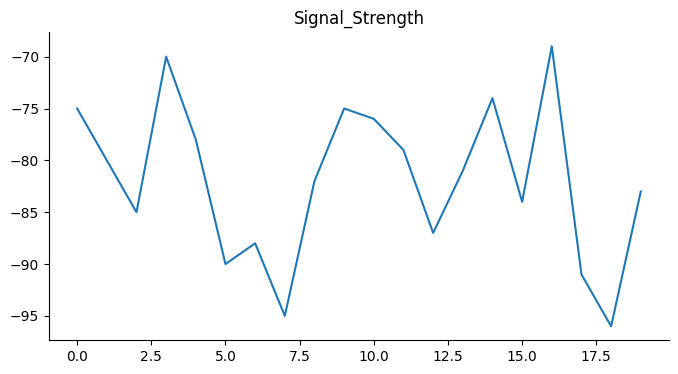

In [ ]:
from matplotlib import pyplot as plt
_df_12['Signal_Strength'].plot(kind='line', figsize=(8, 4), title='Signal_Strength')
plt.gca().spines[['top', 'right']].set_visible(False)

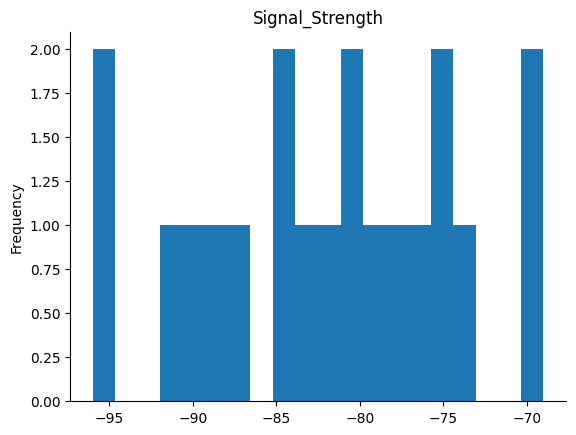

In [ ]:
from matplotlib import pyplot as plt
_df_0['Signal_Strength'].plot(kind='hist', bins=20, title='Signal_Strength')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Define features and targets
features = ['Application_Type', 'Signal_Strength', 'Required_Bandwidth', 'Allocated_Bandwidth', 'Signal_Quality_Category']
target_latency = 'Latency'
target_efficiency = 'Bandwidth_Efficiency'

In [ ]:

# Handling infinities and large values in the dataset
data = data.replace([np.inf, -np.inf], np.nan)
print(data.shape)
data = data.dropna(subset=['Latency', 'Bandwidth_Efficiency'])
print(data.shape)

(400, 10)
(393, 10)


In [ ]:
# Define target variables
y_latency = data[target_latency]
y_efficiency = data[target_efficiency]

In [ ]:
# Train-test split
X = data[features]
X_train_latency, X_test_latency, y_train_latency, y_test_latency = train_test_split(X, y_latency, test_size=0.2, random_state=42)
X_train_efficiency, X_test_efficiency, y_train_efficiency, y_test_efficiency = train_test_split(X, y_efficiency, test_size=0.2, random_state=42)

In [ ]:
# Preprocessing pipelines
categorical_features = ['Application_Type', 'Signal_Quality_Category']
numerical_features = ['Signal_Strength', 'Required_Bandwidth', 'Allocated_Bandwidth']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

In [ ]:
# Model pipelines
models = {
    'Linear Regression': Pipeline(steps=[('preprocessor', preprocessor),
                                         ('regressor', LinearRegression())]),
    'Random Forest': Pipeline(steps=[('preprocessor', preprocessor),
                                      ('regressor', RandomForestRegressor(random_state=42))])
}

In [ ]:
# Model training and evaluation
results = {}
for name, model in models.items():
    print(f'Training {name} for Latency Prediction...')
    model.fit(X_train_latency, y_train_latency)
    y_pred_latency = model.predict(X_test_latency)

    print(f'Training {name} for Bandwidth Efficiency Prediction...')
    model.fit(X_train_efficiency, y_train_efficiency)
    y_pred_efficiency = model.predict(X_test_efficiency)

    # Store results
    results[name] = {
        'Latency': {
            'MAE': mean_absolute_error(y_test_latency, y_pred_latency),
            'RMSE': np.sqrt(mean_squared_error(y_test_latency, y_pred_latency)),
            'R2': r2_score(y_test_latency, y_pred_latency)
        },
        'Efficiency': {
            'MAE': mean_absolute_error(y_test_efficiency, y_pred_efficiency),
            'RMSE': np.sqrt(mean_squared_error(y_test_efficiency, y_pred_efficiency)),
            'R2': r2_score(y_test_efficiency, y_pred_efficiency)
        }
    }

# Display results
results

Training Linear Regression for Latency Prediction...
Training Linear Regression for Bandwidth Efficiency Prediction...
Training Random Forest for Latency Prediction...
Training Random Forest for Bandwidth Efficiency Prediction...


{'Linear Regression': {'Latency': {'MAE': 6.365094420185795,
   'RMSE': 7.946033854829205,
   'R2': 0.8076767901442934},
  'Efficiency': {'MAE': 0.1350199047317324,
   'RMSE': 0.21662304096277932,
   'R2': 0.00029450045440848616}},
 'Random Forest': {'Latency': {'MAE': 1.8966356238698008,
   'RMSE': 4.429782018774095,
   'R2': 0.9402283026952916},
  'Efficiency': {'MAE': 0.03321397254334228,
   'RMSE': 0.09458618553685297,
   'R2': 0.8094020574968452}}}